# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    result['stochastic_network'] = install_options['stochastic_network']
    result['heterogeneous_dgemm'] = install_options['heterogeneous_dgemm']
    return result

simulation_dir_fast = 'paper_sc19/performance/8/'
simulation_files_fast = [simulation_dir_fast + f for f in os.listdir(simulation_dir_fast)]
simulation_dir_slow = 'paper_sc19/performance/9/'
simulation_files_slow = [simulation_dir_slow + f for f in os.listdir(simulation_dir_slow)]

reality_files_fast = [
    '../hpl/grenoble_2018-10-10_1811810.zip',
    '../hpl/grenoble_2018-10-10_1811847.zip',
]
reality_files_slow = [
    '../hpl/grenoble_2019-03-15_1855885.zip',
    '../hpl/grenoble_2019-03-18_1856059.zip',
]
dfsim_fast = pandas.concat([read_sim_result(f) for f in simulation_files_fast])
dfsim_fast['simulation'] = True
dfsim_fast['slow_nodes'] = False
dfsim_fast = dfsim_fast[dfsim_fast.stochastic_cpu & dfsim_fast.stochastic_network & dfsim_fast.polynomial_dgemm & dfsim_fast.heterogeneous_dgemm]
dfsim_slow = pandas.concat([read_sim_result(f) for f in simulation_files_slow])
dfsim_slow['simulation'] = True
dfsim_slow['slow_nodes'] = True
dfsim = pandas.concat([dfsim_fast, dfsim_slow])

dfreal_fast = pandas.concat([read_result(f) for f in reality_files_fast])
dfreal_fast['simulation'] = False
dfreal_fast['slow_nodes'] = False
dfreal_slow = pandas.concat([read_result(f) for f in reality_files_slow])
dfreal_slow['simulation'] = False
dfreal_slow['slow_nodes'] = True
dfreal = pandas.concat([dfreal_fast, dfreal_slow])
df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept,filename,...,simulation,simulation_time,slow_nodes,stochastic_cpu,stochastic_network,swap,sys_time,thread_per_process,time,usr_time
0,154.309,2,128,1.00,1,42.0,42.0,42.0,42.0,paper_sc19/performance/8/grenoble_2019-04-03_1...,...,True,1054.19,False,True,True,0,73.04,1,6.16,981.56
1,453.768,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/performance/8/grenoble_2019-04-03_1...,...,True,3414.20,False,True,True,0,516.21,1,102.12,2892.50
2,860.358,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/performance/8/grenoble_2019-04-03_1...,...,True,7951.47,False,True,True,0,1663.00,1,709.27,6273.40
3,1838.930,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/performance/8/grenoble_2019-04-03_1...,...,True,16797.10,False,True,True,0,4041.20,1,3133.17,12719.06
0,392.288,2,128,0.99,1,42.0,42.0,42.0,42.0,paper_sc19/performance/8/grenoble_2019-04-03_1...,...,True,2850.01,False,True,True,0,341.65,1,62.37,2504.14


### Checking the parameters

In [2]:
dfsim[['dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept']].drop_duplicates()

,dgemm_coefficient,dgemm_intercept,dtrsm_coefficient,dtrsm_intercept
0,42.0,42.0,42.0,42.0


In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,process_per_node,depth,rfact,pfact,thread_per_process,proc_p,block_size,proc_q,bcast,swap,mem_align
0,32,1,2,1,1,32,128,32,2,0,8


In [4]:
dfsim[['stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm']].drop_duplicates()

,stochastic_cpu,polynomial_dgemm,stochastic_network,heterogeneous_dgemm
0,True,True,True,True


In [5]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files_fast + simulation_files_slow]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [6]:
patches = {}
for row in dfsim.iterrows():
    filename = row[1].filename
    slow_nodes = row[1].slow_nodes
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    try:
        patches[slow_nodes].add(hpl[0]['patch'])
    except KeyError:
        patches[slow_nodes] = {(hpl[0]['patch'])}
for slow_nodes, patch in patches.items():
    assert len(patch) == 1
    display(Markdown('### slow_nodes=%s' % slow_nodes))
    display(Markdown('```diff\n%s\n```' % patch.pop()))

### slow_nodes=False

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 
```

### slow_nodes=True

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index a4de021..dd235b7 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -320,6 +320,38 @@ double dgemm_time(double M, double N, double K) {
             mu    = 5.265666e-07 + 6.768453e-11*mnk + -7.996460e-11*mn + 1.666515e-09*mk + 3.016302e-09*nk;
             sigma = 6.399890e-07 + 4.308984e-13*mnk + 2.240832e-11*mn + 5.539865e-11*mk + 6.012762e-11*nk;
             return mu + random_halfnormal_shifted(0, sigma);
+        case 26: // node 13
+            mu    = 5.854250e-07 + 7.920080e-11*mnk + -4.312371e-10*mn + 1.570852e-09*mk + 2.897047e-09*nk;
+            sigma = 6.898829e-07 + 9.474129e-12*mnk + 1.542634e-10*mn + 8.782591e-11*mk + 7.385075e-11*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
+        case 27: // node 13
+            mu    = 5.451164e-07 + 7.640014e-11*mnk + -6.124134e-10*mn + 1.424546e-09*mk + 2.626436e-09*nk;
+            sigma = 6.136947e-07 + 1.383671e-12*mnk + 2.030638e-10*mn + 2.081739e-10*mk + 2.144467e-10*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
+        case 28: // node 14
+            mu    = 5.872356e-07 + 7.825684e-11*mnk + -4.333443e-10*mn + 1.679397e-09*mk + 3.005435e-09*nk;
+            sigma = 7.236303e-07 + 2.564661e-12*mnk + 2.515660e-10*mn + 2.039354e-10*mk + 2.183537e-10*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
+        case 29: // node 14
+            mu    = 5.806772e-07 + 7.879295e-11*mnk + -7.616645e-10*mn + 1.487116e-09*mk + 2.601874e-09*nk;
+            sigma = 7.199230e-07 + 1.651169e-12*mnk + 3.515796e-10*mn + 2.983138e-10*mk + 3.562135e-10*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
+        case 30: // node 15
+            mu    = 6.008916e-07 + 8.450100e-11*mnk + -3.407193e-10*mn + 1.920816e-09*mk + 3.206279e-09*nk;
+            sigma = 6.852550e-07 + 4.222922e-12*mnk + 1.716549e-10*mn + 1.196224e-10*mk + 1.923672e-10*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
+        case 31: // node 15
+            mu    = 6.049290e-07 + 8.384803e-11*mnk + -4.844474e-10*mn + 1.822356e-09*mk + 3.099135e-09*nk;
+            sigma = 7.446548e-07 + 1.080379e-11*mnk + -3.917419e-13*mn + -5.299022e-11*mk + 7.561419e-11*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
+        case 32: // node 16
+            mu    = 5.847983e-07 + 7.985392e-11*mnk + -5.136920e-10*mn + 1.604278e-09*mk + 2.872621e-09*nk;
+            sigma = 7.258348e-07 + 2.105082e-12*mnk + 2.925803e-10*mn + 2.668062e-10*mk + 3.169975e-10*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
+        case 33: // node 16
+            mu    = 5.692598e-07 + 7.703683e-11*mnk + -9.022247e-11*mn + 2.001776e-09*mk + 3.381385e-09*nk;
+            sigma = 7.167982e-07 + 4.668696e-12*mnk + 2.669372e-10*mn + 3.232302e-10*mk + 2.501175e-10*nk;
+            return mu + random_halfnormal_shifted(0, sigma);
         case 34: // node 17
             mu    = 5.344454e-07 + 7.110007e-11*mnk + -4.274161e-10*mn + 1.470139e-09*mk + 2.724523e-09*nk;
             sigma = 6.004602e-07 + 1.634435e-12*mnk + 9.119124e-11*mn + 1.183724e-10*mk + 9.917033e-11*nk;
    
```

### Comparing the simulation with the real execution

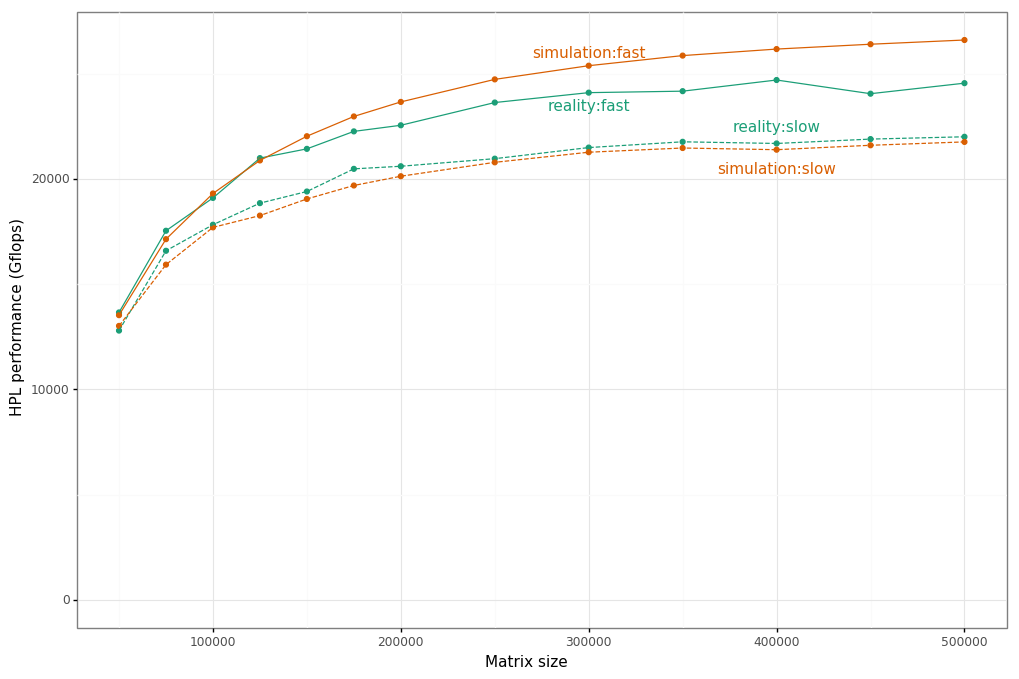

<ggplot: (8732902038059)>

In [7]:
import numpy

# Computing the coordinates for the text...
tmp = pandas.DataFrame({
    'mode': ['simulation:fast', 'simulation:slow', 'reality:fast', 'reality:slow'],
    'simulation': [True, True, False, False],
    'slow_nodes': [True, False, True, False],
    'matrix_size': [3e5, 4e5, 3e5, 4e5],
    'gflops': [2.6e4, 2.05e4, 2.35e4, 2.25e4]
})

plot = ggplot(df, aes(x='matrix_size', y='gflops', color='simulation', linetype='slow_nodes')) + theme_bw() + expand_limits(y=0)
plot = plot + stat_summary(fun_y = numpy.mean, geom='point') + stat_summary(fun_y = numpy.mean, geom='line')
plot = plot + scale_color_brewer(type='qual', palette='Dark2', guide=False) + scale_linetype(guide=False)
plot = plot + geom_text(tmp, aes(x = 'matrix_size', y = 'gflops', label='mode'))
plot = plot + xlab('Matrix size') + ylab('HPL performance (Gflops)') + labs(color='Model')
plot